<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Syntetic-tests-of-cuda-vs-numpy-vs-torch" data-toc-modified-id="Syntetic-tests-of-cuda-vs-numpy-vs-torch-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Syntetic tests of cuda vs numpy vs torch</a></span></li><li><span><a href="#Simulate-with-conv" data-toc-modified-id="Simulate-with-conv-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Simulate with conv</a></span></li></ul></div>

In [1]:
import torch as T
import numpy as np
from itertools import product
from torch.functional import F
import matplotlib.pyplot as plt

import scripts.utils as ising

%load_ext autoreload
%autoreload 2

In [2]:
have_cuda = T.cuda.is_available()
# If ever run this script beter have CUDA
if not have_cuda:
    raise('CUDA not available!')
else:
    print('CUDA ok!')

CUDA ok!


## Syntetic tests of cuda vs numpy vs torch

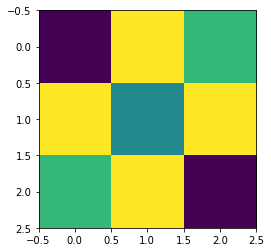

In [238]:
J = .5
mu = 0.1
def get_nn_mask(J, mu):
     return np.array([
         [-J/2, J, J/2]
        ,[J, mu, J]
        ,[J/2, J, -J/2]
    ])
nn_mask = get_nn_mask(J, mu)
plt.imshow(nn_mask)

In [239]:
list(product(range(3),range(3)))

[(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2), (2, 0), (2, 1), (2, 2)]

In [261]:
def get_conv_torch(mask):
    """ Get 2d torch convolution with mask """
    in_chan, out_chan = 1, 1
    shape = mask.shape
    l = T.nn.Conv2d(in_chan, out_chan, shape
                        , stride=shape
                        , padding=0
                        , bias = False
                       )
    l.weight.data = T.from_numpy(mask[np.newaxis, np.newaxis, ...])
    return l

def grid_torch(grid):
    """ Convert 2-d numpy to 4-d torch with shape 1,1,N,N """
    gpu_grid = T.from_numpy(grid[np.newaxis, np.newaxis,...]).double()
    return gpu_grid

def torch_ising(grid, conv, beta):
    
    dE = 2*conv(grid)[0,0]
    
    ixs = np.arange(1, grid.shape[-1]-3, 3)
    ixs = (0,0) + np.ix_(ixs, ixs)
    sub = grid[ixs]
    dE = sub*dE
    
    acc_prob = T.exp(-beta*F.relu(dE))
    random = T.rand_like(acc_prob)
    sub[acc_prob > random] *= -1
    grid[ixs] = sub
    return grid, float(dE.sum().detach()), acc_prob
   

In [262]:
device = T.device('cpu')    

before tensor(-0.0360, dtype=torch.float64)
after tensor(-0.0336, dtype=torch.float64)


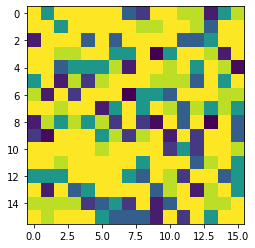

In [263]:
conv = get_conv_torch(nn_mask)
grid = grid_torch(ising.get_random_grid(50))

gr = grid.to(device)
conv = conv.to(device)
print('before', grid.mean())
grid, dE, acc = torch_ising(gr, conv, beta=1/2)
print('after', grid.mean())
plt.imshow(acc.detach().numpy())


## Simulate with conv

In [271]:
sweeps = 80
E = 0

mask = get_nn_mask(.5, 0)
beta = 1/.5
grid = grid_torch(ising.get_random_grid(500)) .to(device)
conv = get_conv_torch(mask)                  .to(device)

E = 0
M = float(grid.mean())
energs = [E]
mags = [M]

In [272]:
for s in range(9*sweeps):
    grid, dE, acc = torch_ising(grid, conv, beta=beta)
    rix = np.random.randint(0,3,2)
    grid = T.roll(grid, tuple(rix), dims=(2,3))
    E += dE
    energs.append(dE)
    mags.append(float(grid.mean()))

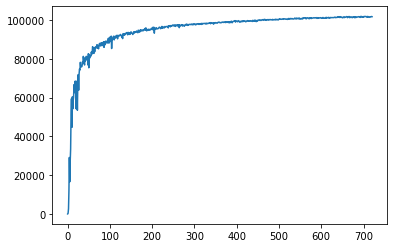

In [273]:
plt.plot(energs)

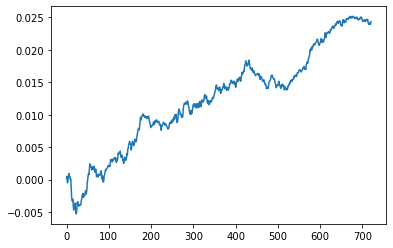

In [274]:
plt.plot(mags)

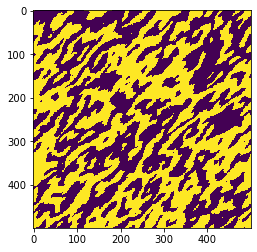

In [275]:
plt.imshow(grid[0,0].detach().numpy())

In [254]:
gr.mean()

tensor(0.0096, dtype=torch.float64)

In [54]:
%%time

r = len(im.flatten())
print(r)
N = 5000
r = int(N**2/9)
rand = np.random.randint(0, N, size=(r, 2))
grid = ising.get_random_grid(N)

for i in range(r):
    dE = ising.metrop_step(grid, rand[i], J, mu, 1/20, N)
    

25000000
CPU times: user 42.5 s, sys: 192 ms, total: 42.7 s
Wall time: 43.1 s


In [55]:
th_time = r*25
print('Theoretical time for loop', th_time, 'microsec')

Theoretical time for loop 69444425 microsec


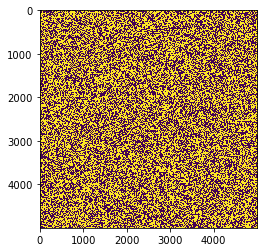

In [56]:
plt.imshow(grid)